# CNN Development

Library Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras import regularizers
from keras import optimizers
from tensorflow.python.client import device_lib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import numpy as np
import gc
import pandas as pd
import os
import librosa
import soundata
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2023-12-02 20:04:02.322051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 20:04:02.497667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-02 20:04:02.498343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 20:04:03.713107: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Feature Extraction

First of all, we need to load the data. Looking at the metadata from the dataset, we can see the target classes, the folds, and the path to the audio files. We will use the path to load the audio files and extract the features.

In [3]:
data_info = pd.read_csv("UrbanSound8K.csv")
data_info

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


Let's see our class distribution

In [4]:
FOLDS_PATH = "../urbansound8k/audio"
DURATION = 4 # 4 seconds for each audio file
SAMPLE_RATE = 22050
HOP_LENGTH = round(SAMPLE_RATE * 0.0125)
WIN_LENGTH = round(SAMPLE_RATE * 0.023)
N_FFT = 2**10
TIME_SIZE = 4*SAMPLE_RATE//HOP_LENGTH+1

In [5]:
def zero_pad(audio_file_path):
    signal, sample_rate = librosa.load(audio_file_path, sr=None)
    # resample the sample rate to the target value of SR
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=SAMPLE_RATE)
    # zero padding
    if len(signal) < DURATION*SAMPLE_RATE:
        signal = np.concatenate([
            signal,
            np.zeros(shape=(DURATION*SAMPLE_RATE - len(signal), ))
        ])
    elif len(signal) > DURATION*SAMPLE_RATE:
        signal = signal[:DURATION*SAMPLE_RATE]
    return signal

### Features & Shapes:

- 2D Mel Spectrogram: (128, 320)

- 2D Chromagram: (121,320)

In [6]:
def process_batch(audio_files, FOLDS_PATH, data_info, SAMPLE_RATE, N_FFT, HOP_LENGTH, WIN_LENGTH):
    batch_data = []
    for audio in audio_files:
        classid = data_info[data_info["slice_file_name"] == os.path.basename(audio)]["classID"].values[0]
        
        audio_data, sample_rate = librosa.load(audio)
        audio_data = librosa.util.fix_length(audio_data, size=int(4 * SAMPLE_RATE))
        
        # Extração de características
        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_chroma=121)

        extract = {
            "fold": fold,
            "mel_spec": mel_spec,
            "chroma": chroma,
            "target": int(classid)
        }
        batch_data.append(extract)

    return batch_data


BATCH_SIZE = 50  # Ajuste conforme necessário para se adequar à sua memória

# Obter todos os folds e inicializar o DataFrame
folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
all_data = []

for fold in folds:
    audio_files = librosa.util.find_files(os.path.join(FOLDS_PATH, fold))
    audio_files = audio_files[:len(audio_files) // 4]
    for i in range(0, len(audio_files), BATCH_SIZE):
        batch_files = audio_files[i:i+BATCH_SIZE]
        batch_data = process_batch(batch_files, FOLDS_PATH, data_info, SAMPLE_RATE, N_FFT, HOP_LENGTH, WIN_LENGTH)
        all_data.extend(batch_data)
    print(f"Fim do {fold}")
    gc.collect()

df_data = pd.DataFrame(all_data, columns=["fold", "mel_spec", "chroma", "target"])
print("Dataset Completo")

Fim do fold1
Fim do fold10
Fim do fold2
Fim do fold3
Fim do fold4
Fim do fold5
Fim do fold6
Fim do fold7
Fim do fold8
Fim do fold9
Dataset Completo


In [7]:
ohe_targets = np.zeros(
        shape=(df_data['target'].size, df_data['target'].max()+1))
ohe_targets[np.arange(df_data['target'].size),
            df_data['target'].to_numpy(dtype=np.int16)] = 1
df_data['target'] = ohe_targets.tolist()
df_data['target'].apply(np.array)

0       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
                              ...                        
1082    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1083    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1084    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1085    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1086    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
Name: target, Length: 1087, dtype: object

Let's save into some variables the future shape of the inputs, as the 1D features will be all stacked, the model input for those will have 4 channels.

In [8]:
mel_shape = (128,320, 1)
chroma_shape = (121,320, 1)

## Modelo

In [9]:
def create_model():
    melinput = layers.Input(shape=mel_shape, name='mel_spectogram_input')

    mel = layers.Conv2D(8, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer='he_normal')(melinput)
    mel = layers.MaxPooling2D(padding='same', pool_size=(2, 2))(mel)
    mel = layers.Dropout(0.2)(mel)
    mel = layers.Flatten()(mel)

    chromainput = layers.Input(shape=chroma_shape, name='chromagram_input')

    chroma = layers.Conv2D(8, kernel_size=3, strides=2, activation="relu", kernel_initializer='he_normal')(chromainput)
    chroma = layers.MaxPooling2D(padding='same', pool_size=(2, 2))(chroma)
    chroma = layers.Dropout(0.2)(chroma)
    chroma = layers.Flatten()(chroma)

    combined = layers.concatenate([mel, chroma])

    combined = layers.Dense(128, activation="relu", kernel_initializer='he_normal')(combined)
    combined = layers.Dropout(0.2)(combined)

    output = layers.Dense(10, activation='softmax')(combined)

    model = keras.Model(inputs=[melinput, chromainput], outputs=[output])

    return model


In [10]:
model = create_model()

adam = optimizers.Adam(lr=0.001)

model.compile(
        optimizer=adam,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mel_spectogram_input (InputLay  [(None, 128, 320, 1  0          []                               
 er)                            )]                                                                
                                                                                                  
 chromagram_input (InputLayer)  [(None, 121, 320, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 160, 8)   80          ['mel_spectogram_input[0][0]']   
                                                                                              

2023-12-02 20:05:59.848477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 20:05:59.973263: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


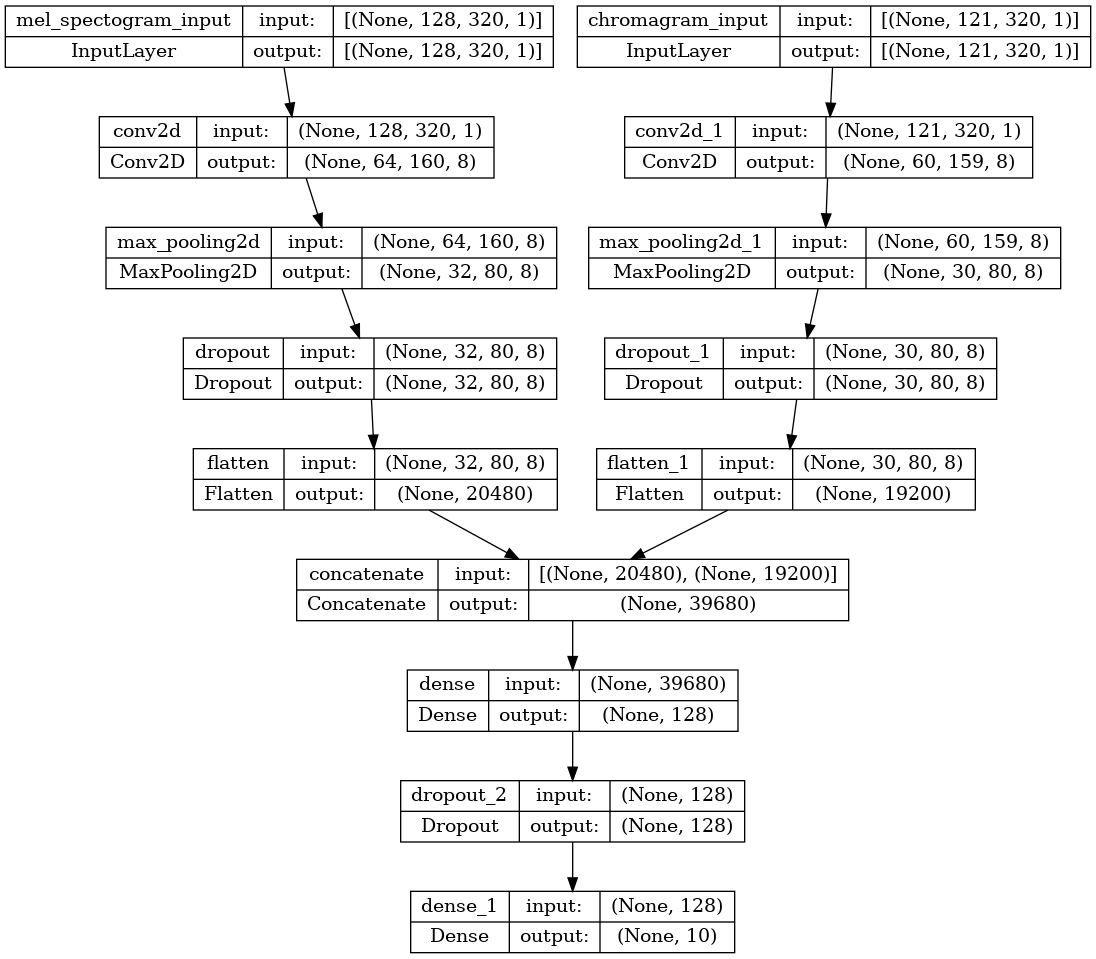

In [11]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

## Data Reshaping

With our model ready to be trained, we just have to separate our data into the training, testing and validation sets. We will also reshape the 1D data to become a NumPy stack.

In [16]:
def ready_data(fold, df_data):
    print("Iniciando o processamento do fold:", fold)

    # Dividir o DataFrame original em treino e teste
    X_test = df_data[df_data["fold"] == fold]
    X_train = df_data[df_data["fold"] != fold]

    # Separar os targets (mantendo a codificação one-hot)
    y_train = np.array(X_train["target"].tolist())
    y_test = np.array(X_test["target"].tolist())

    # Carregar os dados de espectrogramas e cromagramas
    X_train_mel = np.asarray(X_train["mel_spec"].to_list()).astype(np.float32)
    X_train_chroma = np.asarray(X_train["chroma"].to_list()).astype(np.float32)

    # Dividir o conjunto de teste em teste e validação
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, random_state=42
    )

    # Processar características de validação e teste
    X_val_mel = np.asarray(X_val["mel_spec"].to_list()).astype(np.float32)
    X_val_chroma = np.asarray(X_val["chroma"].to_list()).astype(np.float32)
    X_test_mel = np.asarray(X_test["mel_spec"].to_list()).astype(np.float32)
    X_test_chroma = np.asarray(X_test["chroma"].to_list()).astype(np.float32)

    # Liberação de memória
    del X_train, X_val, X_test
    gc.collect()

    return X_train_mel, X_train_chroma, y_train, X_val_mel, X_val_chroma, y_val, X_test_mel, X_test_chroma, y_test


## Metric Variables

And, to analyse the 10 models made in the 10 fold cross validation, we will keep useful info in some arrays.

## 10-Fold Cross Validation

The model will be fit using the Adam optimizar, we will use categorical (hence why we one hot encoded the class labels) crossentropy as our loss function, and we will use accuracy to analyse how well our model performs.

We will also input the data in batches of 64, and, from previous testings, we will define the number of epochs to 50, as more start to take too much time to train with a low yield of results.

In [ ]:
EPOCHS = 10
fold_metrics = {}

for i in range(1,11):
    fold = "fold" + str(i)
    print("Fold " + str(i) + ":")

    # Reinicialize seu modelo aqui
    print("ai")
    
    model = create_model()  # Certifique-se de que esta função reconstrói o modelo do zero
    print("ai")
    
    adam = optimizers.Adam(lr=0.001)

    model.compile(
        optimizer=adam,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Prepare os dados
    X_train_mel, X_train_chroma, y_train, X_val_mel, X_val_chroma, y_val, X_test_mel, X_test_chroma, y_test = ready_data(fold,df_data)
    print("ai")

    # Treinamento do modelo
    history = model.fit(
        {'mel_spectogram_input': X_train_mel, 'chromagram_input': X_train_chroma},
        y=y_train,
        validation_data=({'mel_spectogram_input': X_val_mel, 'chromagram_input': X_val_chroma}, y_val),
        epochs=EPOCHS,
        batch_size=32
    )
    print("ai")

    # Avaliação do modelo
    evaluation = model.evaluate(x={'mel_spectogram_input': X_test_mel, 'chromagram_input': X_test_chroma}, y=y_test)
    y_pred = model.predict(x={'mel_spectogram_input': X_test_mel, 'chromagram_input': X_test_chroma})
    print("ai")

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    print("ai")

    # Salvando métricas
    m_metrics = {'loss': evaluation[0], 'accuracy': evaluation[1], 'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 'history': history.history}
    fold_metrics[f"fold{i}"] = m_metrics
    print("ai")

# Liberação de memória
gc.collect()

print("Done.")

Fold 1:
ai
ai
Iniciando o processamento do fold: fold1
ai
Epoch 1/10
31/31 [==============================] - 2s 65ms/step - loss: 212.8748 - accuracy: 0.1513 - val_loss: 2.2994 - val_accuracy: 0.2364
Epoch 2/10
27/31 [=========================>....] - ETA: 3s - loss: 2.8429 - accuracy: 0.2766

## Model Analysis

### Accuracy & Loss 

KeyError: 0

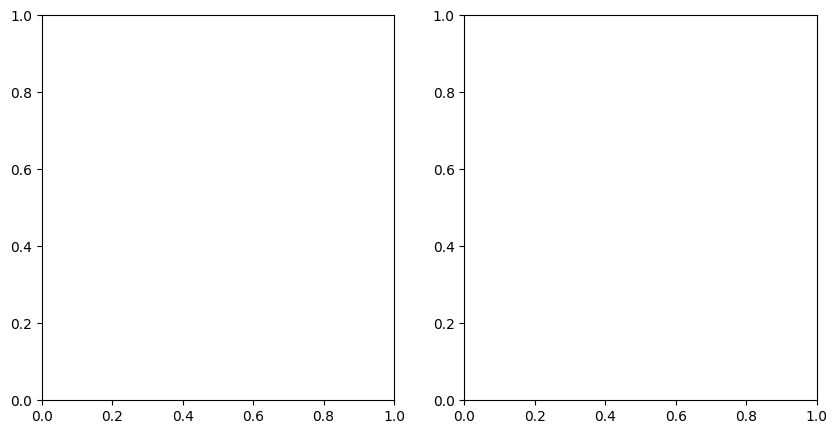

In [14]:
EPOCHS = 50

import matplotlib.pyplot as plt
epochs = range(1, EPOCHS + 1)

fig, ax = plt.subplots(len(fold_metrics),2,figsize=(10,5*len(fold_metrics)))

for i in range(0,len(fold_metrics)):
    history_dict = fold_metrics[i].get('history_dict')
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    ax[i,0].plot(epochs,loss_values,'co',label='Training Loss')
    ax[i,0].plot(epochs,val_loss_values,'m', label='Validation Loss')
    ax[i,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].set_ylabel('Loss')
    ax[i,0].legend()

    ax[i,1].plot(epochs,acc_values,'co', label='Training accuracy')
    ax[i,1].plot(epochs,val_acc_values,'m', label='Validation accuracy')
    ax[i,1].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].legend()
plt.show()

It is worth noting that as the loss is continuous and the class labels are categorical, we can see some seemingly random jumps in the validation accuracy. This is due to the fact that as the loss keeps getting lower, some classification might be categorized incorrectly, altough the model keeps getting closer to correct classifications. We can notice the "rubber banding" of the accuracy catching up with training loss as more epochs go by.

Altough we only trained 50 epochs, as the training and validation loss did not start receding / showing signs of overfitting, we can safely assume more epochs will yield a model with better accuracy.

### Average Accuracy and Standard Deviation

In [15]:
avg_train_acc = 0
train_lst = []
for i in fold_metrics:
    avg_train_acc += max(i.get('history_dict').get('accuracy'))
    train_lst.append(max(i.get('history_dict').get('accuracy')))
    
print("%.4f +- %.4f average train accuracy across all folds." % (avg_train_acc/len(fold_metrics) , np.std(train_lst)))

avg_val_acc = 0
val_lst = []
for i in fold_metrics:
    avg_val_acc += max(i.get('history_dict').get('val_accuracy'))
    val_lst.append(max(i.get('history_dict').get('val_accuracy')))

print("%.4f +- %.4f average validation accuracy across all folds." %(avg_val_acc / len(fold_metrics), np.std(val_lst)))

avg_test_acc = 0
test_lst = []
for i in fold_metrics:
    avg_test_acc += i.get('accuracy')
    test_lst.append(i.get('accuracy'))

print("%.4f +- %.4f average test accuracy across all folds." % (avg_test_acc / len(fold_metrics), np.std(test_lst)))

AttributeError: 'str' object has no attribute 'get'

We can see that the model provides sufficiently good results, with ~80% accuracy on the training, and between 65-70% in both validation and testing sets.

### Confusion Matrix

We can also see the confusion matrices of every fold, they all look pretty similar. We can notice some points where the model clearly failed to predict some of the classes, but overall, it looks good.

In [ ]:
import seaborn as sns

fig, ax =plt.subplots(5, 2, figsize=(15,3*len(fold_metrics)))

for i in range(0,len(fold_metrics)):
    cm = fold_metrics[i].get('confusion_matrix')
    ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
    ax[i//2,i%2].set_xlabel('Predicted label')
    ax[i//2,i%2].set_ylabel('Actual label')
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'RdYlGn', ax=ax[i//2,i%2])

plt.show()


And here we have the sum of all confusion matrices:

In [ ]:
cm = np.zeros(shape=(10,10))
for i in fold_metrics:
    cm += i.get('confusion_matrix')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = cm * 100


fig, ax =plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Confusion matrix on all folds')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
ax.invert_yaxis()
sns.heatmap(cm, annot=True, fmt=".2f %", linewidths=.5, square = True, cmap = 'RdYlGn', ax=ax)
